In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.tree import plot_tree
from joblib import dump, load

In [3]:
df = pd.read_csv("macro-economic-db-quarterly.csv", delimiter=";", index_col=0)
df = df.transpose()

df.reset_index(inplace=True)
df.rename(columns={"index":"stvrtrok"}, inplace=True)
for column in df.columns[1:]:
    df[column] = df[column].str.replace(",", "").astype(float)

columns_to_modify = df.columns.difference(["urok"])
df[columns_to_modify] = df[columns_to_modify].replace(0, np.nan)

df["bilancia"] = df.vyvoz - df.dovoz

df["NaN_Percentage"] = df.isna().sum(axis=1) / df.shape[1] * 100
df_cut =  df[df["NaN_Percentage"] <= 30].drop(columns=["NaN_Percentage"])
df_cut.reset_index(drop=True, inplace=True)

df_clean = df_cut.bfill()
df_clean = df_clean.ffill()

In [17]:
import pandas as pd

# Load your dataset (assuming it's in a CSV file)


# Calculate Pearson correlation between GDP (HDP) and Labor Force (Pracovná sila)
correlation = df_clean["ppi"].corr(df_clean["hicp"])
print("Pearson Correlation:", correlation)

Pearson Correlation: 0.8850778558289795


In [4]:
#Rozdelenie dát

#HDP
X_hdp = df_clean[df_clean.columns.difference(["hdp", "stvrtrok"])]
y_hdp = df_clean.hdp
X_train_hdp, X_test_hdp, y_train_hdp, y_test_hdp = train_test_split(X_hdp, y_hdp, test_size=0.2, random_state=42)


#Nezamestnanosť
X_nezamestnanost = df_clean[df_clean.columns.difference(["nezamestnanost", "stvrtrok"])]
y_nezamestnanost = df_clean.nezamestnanost
X_train_nezamestnanost, X_test_nezamestnanost, y_train_nezamestnanost, y_test_nezamestnanost = train_test_split(X_nezamestnanost, y_nezamestnanost, test_size=0.2, random_state=42)


#Inflácia
X_cpi = df_clean[df_clean.columns.difference(["cpi", "stvrtrok"])]
y_cpi = df_clean.cpi
X_train_cpi, X_test_cpi, y_train_cpi, y_test_cpi = train_test_split(X_cpi, y_cpi, test_size=0.2, random_state=42)


In [5]:
# Náhodný les pre HDP
rf_model_hdp = RandomForestRegressor(random_state=42)


param_grid_hdp = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5, 6, 8, 10, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


grid_search_hdp = GridSearchCV(
    estimator=rf_model_hdp,
    param_grid=param_grid_hdp,
    cv=5,
    scoring=mape_scorer,
    n_jobs=-1
)


grid_search_hdp.fit(X_train_hdp, y_train_hdp)


best_params_hdp = grid_search_hdp.best_params_
best_model_hdp = grid_search_hdp.best_estimator_

print("Najlepšie hyperparamtere:", best_params_hdp)


y_pred_hdp = best_model_hdp.predict(X_test_hdp)
mae_hdp = mean_absolute_error(y_test_hdp, y_pred_hdp)
mse_hdp = mean_squared_error(y_test_hdp, y_pred_hdp)
rmse_hdp = np.sqrt(mse_hdp)
mape_hdp = mean_absolute_percentage_error(y_test_hdp, y_pred_hdp)
r2_hdp = r2_score(y_test_hdp, y_pred_hdp)

print(f"(MAE): {mae_hdp}")
print(f"(MSE): {mse_hdp}")
print(f"(MSE): {rmse_hdp}")
print(f"(MAPE): {mape_hdp}")
print(f"R²: {r2_hdp}")


Najlepšie hyperparamtere: {'criterion': 'absolute_error', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
(MAE): 215.06442354347342
(MSE): 84635.90406560547
(MSE): 290.9225052580248
(MAPE): 0.013661646839567547
R²: 0.9967916536440166


* Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
* Mean Absolute Error (MAE): 215.06442354347342
* Mean Squared Error (MSE): 84635.90406560547
* Root Mean Squared Error (MSE): {rmse_hdp}
* Mean Absolute Percentage Error(MAPE): 0.013661646839567547
* R² Score: 0.9967916536440166

In [6]:

rf_model_nezamestnanost = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid_nezamestnanost = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5, 6, 8, 10, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Set up GridSearchCV
grid_search_nezamestnanost = GridSearchCV(
    estimator=rf_model_nezamestnanost,
    param_grid=param_grid_nezamestnanost,
    cv=5,  # 5-fold cross-validation
    scoring=mape_scorer,
    n_jobs=-1  # Utilize all available cores
)

# Fit GridSearchCV
grid_search_nezamestnanost.fit(X_train_nezamestnanost, y_train_nezamestnanost)

# Get the best parameters and model
best_params_nezamestnanost = grid_search_nezamestnanost.best_params_
best_model_nezamestnanost = grid_search_nezamestnanost.best_estimator_

print("Najlepšie hyperparametre:", best_params_nezamestnanost)

# Evaluate the best model
y_pred_nezamestnanost = best_model_nezamestnanost.predict(X_test_nezamestnanost)
mae_nezamestnanost = mean_absolute_error(y_test_nezamestnanost, y_pred_nezamestnanost)
mse_nezamestnanost = mean_squared_error(y_test_nezamestnanost, y_pred_nezamestnanost)
rmse_nezamestnanost = np.sqrt(mse_nezamestnanost)
mape_nezamestnanost = mean_absolute_percentage_error(y_test_nezamestnanost, y_pred_nezamestnanost)
r2_nezamestnanost = r2_score(y_test_nezamestnanost, y_pred_nezamestnanost)

print(f"(MAE): {mae_nezamestnanost}")
print(f"(MSE): {mse_nezamestnanost}")
print(f"(RMSE): {rmse_nezamestnanost}")
print(f"(MAPE): {mape_nezamestnanost}")
print(f"R²: {r2_nezamestnanost}")



Najlepšie hyperparametre: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
(MAE): 0.4424317173913092
(MSE): 0.43443487487482024
(RMSE): 0.6591167384271319
(MAPE): 0.03824208369599578
R²: 0.9714003475588526


* Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
* Mean Absolute Error (MAE): 0.4424317173913092
* Mean Squared Error (MSE): 0.43443487487482024
* Root Mean Squared Error (MSE): {rmse_nezamestnanost}
* Mean Absolute Percentage Error(MAPE): 0.03824208369599578
* R² Score: 0.9714003475588526

In [7]:
rf_model_cpi = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid_cpi = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5, 6, 8, 10, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Set up GridSearchCV
grid_search_cpi = GridSearchCV(
    estimator=rf_model_cpi,
    param_grid=param_grid_cpi,
    cv=5,  # 5-fold cross-validation
    scoring=mape_scorer,
    n_jobs=-1  # Utilize all available cores
)

# Fit GridSearchCV
grid_search_cpi.fit(X_train_cpi, y_train_cpi)

# Get the best parameters and model
best_params_cpi = grid_search_cpi.best_params_
best_model_cpi = grid_search_cpi.best_estimator_

print("Najlepšie hyperparametre:", best_params_cpi)

# Evaluate the best model
y_pred_cpi = best_model_cpi.predict(X_test_cpi)
mae_cpi = mean_absolute_error(y_test_cpi, y_pred_cpi)
mse_cpi = mean_squared_error(y_test_cpi, y_pred_cpi)
rmse_cpi = np.sqrt(mse_cpi)
mape_cpi = mean_absolute_percentage_error(y_test_cpi, y_pred_cpi)
r2_cpi = r2_score(y_test_cpi, y_pred_cpi)

print(f"(MAE): {mae_cpi}")
print(f"(MSE): {mse_cpi}")
print(f"(RMSE): {rmse_cpi}")
print(f"(MAPE): {mape_cpi}")
print(f"R²: {r2_cpi}")




Najlepšie hyperparametre: {'criterion': 'squared_error', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
(MAE): 1.4058770129861542
(MSE): 4.042259843629591
(RMSE): 2.010537202746965
(MAPE): 0.010651272285485104
R²: 0.99812346029647


* Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
* Mean Absolute Error (MAE): 1.4058770129861542
* Mean Squared Error (MSE): 4.042259843629591
* Root Mean Squared Error (RMSE): 2.010537202746965
* Mean Absolute Percentage Error(MAPE): 0.010651272285485104
* R² Score: 0.99812346029647

In [8]:
#Uloženie modelov

dump(best_model_hdp, 'best_model_hdp_rf.joblib')
dump(best_model_nezamestnanost, 'best_model_nezamestnanost_rf.joblib')
dump(best_model_cpi, 'best_model_cpi_rf.joblib')

['best_model_cpi_rf.joblib']

In [9]:
#Načítanie modelov

rf_loaded_hdp = load('best_model_hdp_rf.joblib')
rf_loaded_nezamestnanost = load('best_model_nezamestnanost_rf.joblib')
rf_loaded_cpi = load('best_model_cpi_rf.joblib')

# Výsledky

In [10]:
#Metriky

hdp_pred_loaded = rf_loaded_hdp.predict(X_test_hdp)
nezamestnanost_pred_loaded = rf_loaded_nezamestnanost.predict(X_test_nezamestnanost)
cpi_pred_loaded = rf_loaded_cpi.predict(X_test_cpi)

mae_nezamestnanost_loaded = mean_absolute_error(y_test_nezamestnanost, nezamestnanost_pred_loaded)
mse_nezamestnanost_loaded = mean_squared_error(y_test_nezamestnanost, nezamestnanost_pred_loaded)
rmse_nezamestnanost_loaded = np.sqrt(mse_nezamestnanost_loaded)
mape_nezamestnanost_loaded = mean_absolute_percentage_error(y_test_nezamestnanost, nezamestnanost_pred_loaded)
r2_nezamestnanost_loaded = r2_score(y_test_nezamestnanost, nezamestnanost_pred_loaded)


mae_hdp_loaded = mean_absolute_error(y_test_hdp, hdp_pred_loaded)
mse_hdp_loaded = mean_squared_error(y_test_hdp, hdp_pred_loaded)
rmse_hdp_loaded = np.sqrt(mse_hdp_loaded)
mape_hdp_loaded = mean_absolute_percentage_error(y_test_hdp, hdp_pred_loaded)
r2_hdp_loaded = r2_score(y_test_hdp, hdp_pred_loaded)


mae_cpi_loaded = mean_absolute_error(y_test_cpi, cpi_pred_loaded)
mse_cpi_loaded = mean_squared_error(y_test_cpi, cpi_pred_loaded)
rmse_cpi_loaded = np.sqrt(mse_cpi_loaded)
mape_cpi_loaded = mean_absolute_percentage_error(y_test_cpi, cpi_pred_loaded)
r2_cpi_loaded = r2_score(y_test_cpi, cpi_pred_loaded)

metrics = {
    "Cieľová premenná": [
        "HDP",
        "Nezamestnanosť",
        "Inflácia"
    ],
    "MSE": [
        mse_hdp_loaded,
        mse_nezamestnanost_loaded,
        mse_cpi_loaded
    ],
    "MAE": [
        mae_hdp_loaded,
        mae_nezamestnanost_loaded,
        mae_cpi_loaded,
    ],
    "RMSE": [
        rmse_hdp_loaded,
        rmse_nezamestnanost_loaded,
        rmse_cpi_loaded
    ],
    "MAPE": [
        mape_hdp_loaded,
        mape_nezamestnanost_loaded,
        mape_cpi_loaded
    ],
    "R2": [
        r2_hdp_loaded,
        r2_nezamestnanost_loaded,
        r2_cpi_loaded
    ]
}

df_metrics = pd.DataFrame(metrics)
df_metrics





,Cieľová premenná,MSE,MAE,RMSE,MAPE,R2
0,HDP,84635.904066,215.064424,290.922505,0.013662,0.996792
1,Nezamestnanosť,0.434435,0.442432,0.659117,0.038242,0.971400
2,Inflácia,4.042260,1.405877,2.010537,0.010651,0.998123


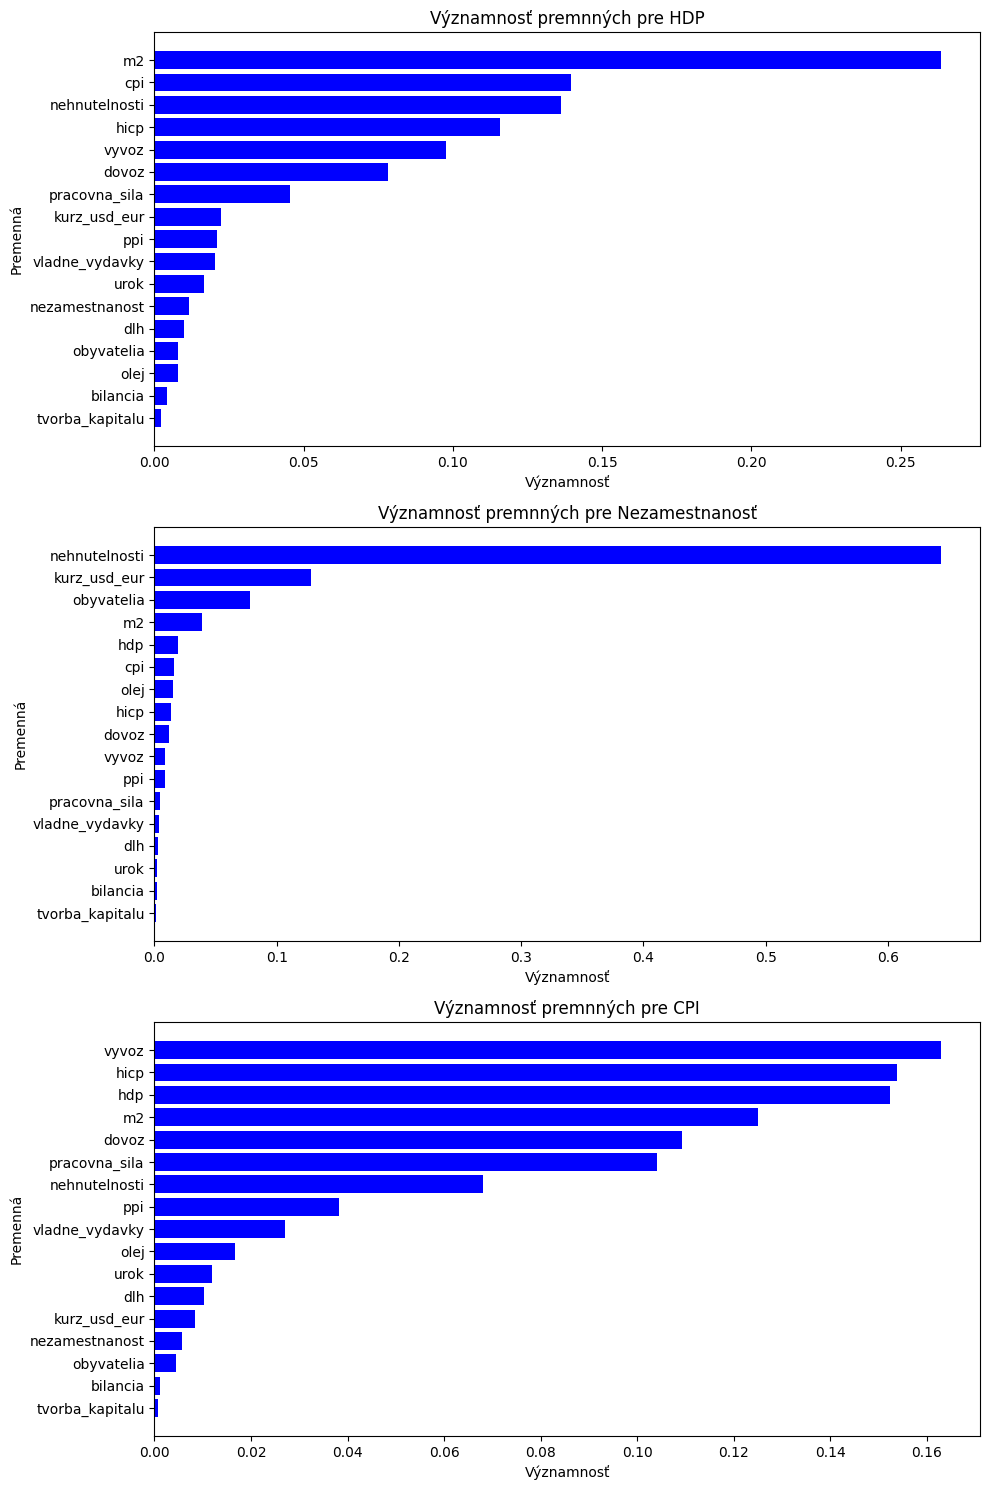

In [11]:
#Významnosť premnných
models = {
    "hdp": rf_loaded_hdp,
    "nezamestnanost": rf_loaded_nezamestnanost,
    "cpi": rf_loaded_cpi
}


feature_importance_results = {}


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))


for idx, (target, model) in enumerate(models.items()):

    
    X = eval(f"X_train_{target}")

    
    importances = model.feature_importances_
    feature_names = X.columns

    
    feature_importance_df = pd.DataFrame({
        "Premenná": feature_names,
        "Významnosť": importances
    }).sort_values(by="Významnosť", ascending=False)

    
    feature_importance_results[target] = feature_importance_df

    if target == "hdp":
        target = "HDP"
    elif target == "cpi":
        target = "CPI"
    else:
        target = "Nezamestnanosť"
    
    axes[idx].barh(feature_importance_df["Premenná"], feature_importance_df["Významnosť"], color="blue")
    axes[idx].set_xlabel("Významnosť")
    axes[idx].set_ylabel("Premenná")
    axes[idx].set_title(f"Významnosť premnných pre {target}")
    axes[idx].invert_yaxis()


plt.tight_layout()
plt.show()


